# Semi-synthetic Spellmatch parameter optimization

- Hand-picked images from Jackson & Fischer et al.
- Fixed simutome parameters, 1 section per image
- Spellmatch algorithm only
    - Cell exclusion only
    - Fixed adjancy radius of $15 \mu m$
    - Varying similarity/prior weights

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
results_info = pd.read_csv("results/results.csv")
assert results_info["error"].isna().all()

## Assignment strategy (pre-selection)

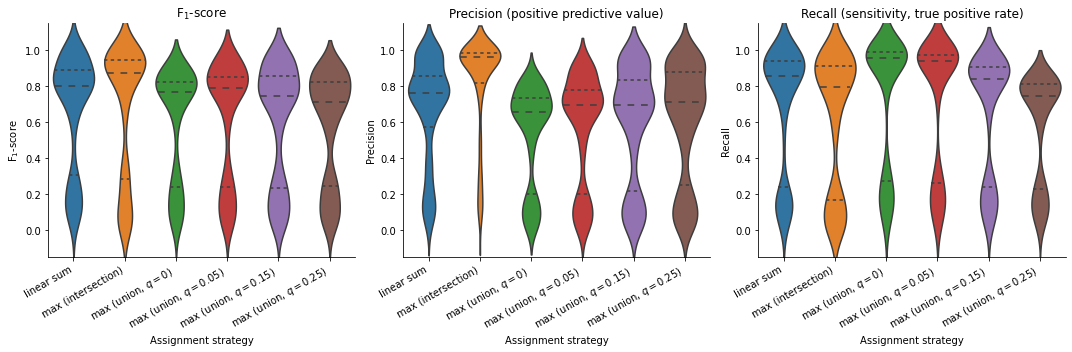

In [3]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=results_info,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Parameter selection

In [4]:
df = results_info[results_info["metric_name"] == "f1score"]
df = pd.DataFrame(
    data={
        "alpha": df["spellmatch_alpha"],
        "degree_weight": df["spellmatch_degree_weight"],
        "intensity_weight": df["spellmatch_intensity_weight"],
        "distance_weight": df["spellmatch_distance_weight"],
        "f1score": df["metric_value"],
    }
)

In [5]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.6909340218804653

In [6]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

alpha               0.865388
intensity_weight    0.060665
degree_weight       0.039387
distance_weight     0.034560
Name: Gini importance, dtype: float64

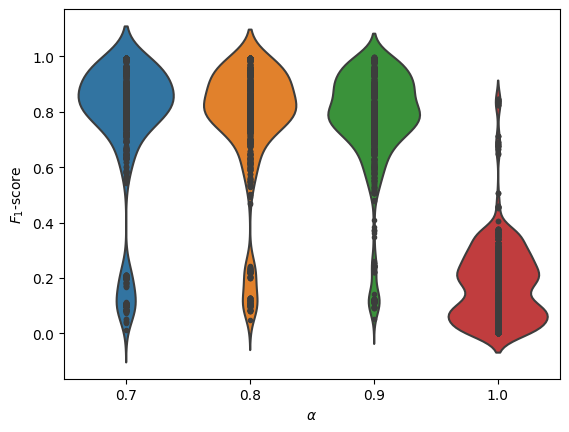

In [7]:
sns.violinplot(data=df, x="alpha", y="f1score", inner="point")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $\lambda = 0.8$

In [8]:
df = df[df["alpha"] == 0.8]

In [9]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.228444740851366

In [10]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

distance_weight     0.354755
intensity_weight    0.326898
degree_weight       0.318347
alpha               0.000000
Name: Gini importance, dtype: float64

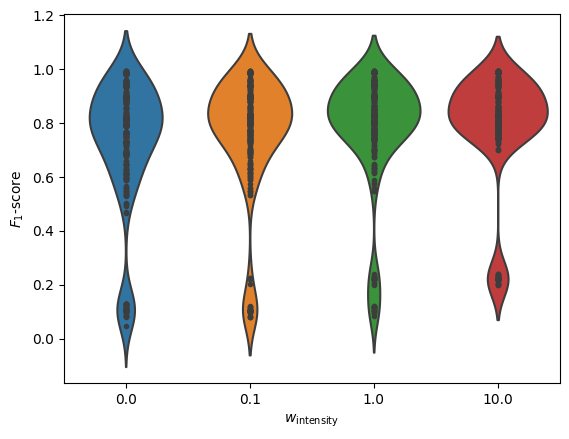

In [11]:
sns.violinplot(data=df, x="intensity_weight", y="f1score", inner="point")
plt.xlabel(r"$w_\mathrm{intensity}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{intensity} = 1$ as reference (all weights are relative)

In [12]:
df = df[df["intensity_weight"] == 1]

In [13]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.22201737290714163

In [14]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

degree_weight       0.652901
distance_weight     0.347099
alpha               0.000000
intensity_weight    0.000000
Name: Gini importance, dtype: float64

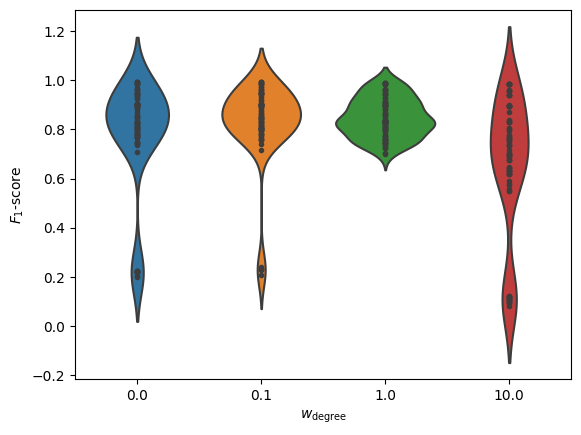

In [15]:
sns.violinplot(data=df, x="degree_weight", y="f1score", inner="point")
plt.xlabel(r"$w_\mathrm{degree}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{degree} = 1$

In [16]:
df = df[df["degree_weight"] == 1]

In [17]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.027663721677547493

In [18]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

distance_weight     1.0
alpha               0.0
degree_weight       0.0
intensity_weight    0.0
Name: Gini importance, dtype: float64

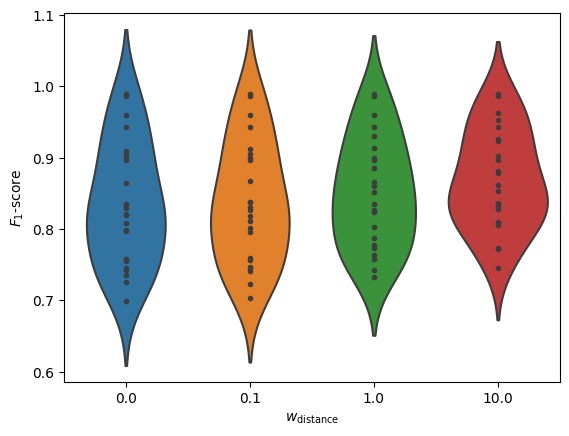

In [19]:
sns.violinplot(data=df, x="distance_weight", y="f1score", inner="point")
plt.xlabel(r"$w_\mathrm{distance}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{distance} = 10$

In [20]:
df = df[df["distance_weight"] == 10]

## Assignment strategy (post-selection)

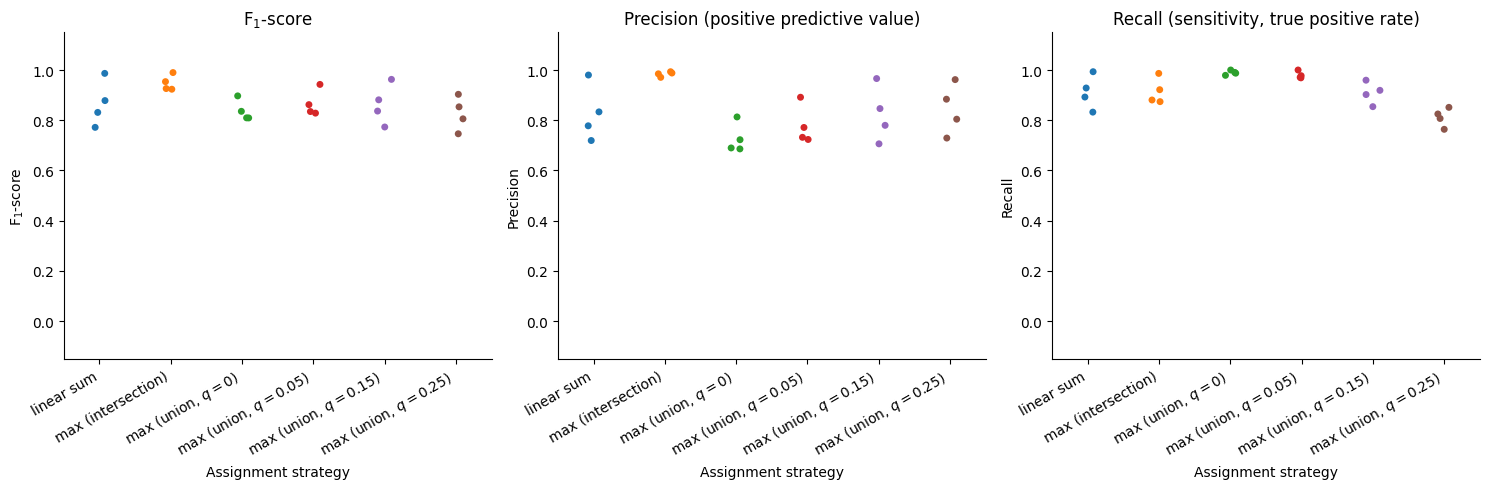

In [21]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=results_info[
        (results_info["spellmatch_alpha"] == 0.8)
        & (results_info["spellmatch_degree_weight"] == 1)
        & (results_info["spellmatch_intensity_weight"] == 1)
        & (results_info["spellmatch_distance_weight"] == 10)
    ],
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="strip",
    sharex=False,
    sharey=False,
    #inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Matching performance/uncertainty

In [22]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_alpha"] == 0.8)
    & (results_info["spellmatch_degree_weight"] == 1)
    & (results_info["spellmatch_intensity_weight"] == 1)
    & (results_info["spellmatch_distance_weight"] == 10)
    & (results_info["assignment_name"] == "max_intersect")
]

In [23]:
df.pivot(index=["points_file_name"], columns="metric_name", values="metric_value")[
    [
        "f1score", "precision", "recall",
        "uncertainty_mean", "uncertainty_std",
        "margin_mean", "margin_std",
        "entropy_mean", "entropy_std",
    ]
]

metric_name,f1score,precision,recall,uncertainty_mean,uncertainty_std,margin_mean,margin_std,entropy_mean,entropy_std
points_file_name,,,,,,,,,
dense_heterogeneous.csv,0.926148,0.984839,0.874058,0.695776,0.036920,0.027169,0.021170,6.611172,1.974179
dense_homogeneous.csv,0.953682,0.988004,0.921664,0.447963,0.068862,0.063299,0.040427,7.534185,1.423267
sparse_heterogeneous.csv,0.923505,0.970760,0.880637,0.655724,0.179016,0.071515,0.071399,2.653559,1.993854
sparse_homogeneous.csv,0.989831,0.993197,0.986486,0.733542,0.216591,0.143077,0.071060,0.455699,0.334997
